In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

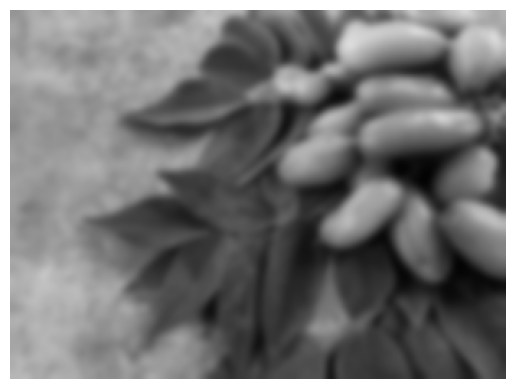

In [ ]:
## PASSO 1 - Redimensionamento

# Carrega a imagem
imagem = cv2.imread('imagem_5.jpg')

# Obtém a altura e largura da imagem
altura, largura = imagem.shape[:2]

# Calcula a nova altura e largura para ser um múltiplo de 8
nova_altura = (altura // 8) * 8
nova_largura = (largura // 8) * 8

# Redimensiona a imagem para a nova altura e largura
imagem_redimensionada = cv2.resize(imagem, (nova_largura, nova_altura))

imagem_grayscale = cv2.cvtColor(imagem_redimensionada, cv2.COLOR_BGR2GRAY)
imagem_blur = cv2.GaussianBlur(imagem_grayscale, (15, 15), 0)

# Exibe a imagem redimensionada
plt.imshow(cv2.cvtColor(imagem_blur, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
## PASSO 2 - Magnitude e orientação de cada pixel

# Calcula as derivadas parciais em relação a x e y
dX = cv2.filter2D(imagem_blur, cv2.CV_64F, np.array([[-1, 0, 1]]))
dY = cv2.filter2D(imagem_blur, cv2.CV_64F, np.array([[-1], [0], [1]]))

# Calcula a magnitude e orientação
magnitude = np.sqrt(dX**2 + dY**2)
orientacao = np.arctan2(dY, dX)

orientacao = np.degrees(orientacao)

In [ ]:
## PASSO 3 & 4 - Dividir a imagem em células de 8x8 pixels & Para cada célula 8x8, calcula-se um histograma de orientações.

# Divide a imagem em células de 8x8 pixels
num_celulas_x = nova_largura // 8
num_celulas_y = nova_altura // 8

# Inicializa um array para armazenar os histogramas de orientações
histogramas = np.zeros((num_celulas_y, num_celulas_x, 9), dtype=np.float32)

# Itera sobre as células
for y in range(num_celulas_y):
    for x in range(num_celulas_x):
        # Obtém a região da célula
        regiao_orientacao = orientacao[y*8:(y+1)*8, x*8:(x+1)*8]
        regiao_magnitude = magnitude[y*8:(y+1)*8, x*8:(x+1)*8]

        # Calcula o histograma de orientações
        hist, _ = np.histogram(regiao_orientacao, bins=9, range=(-np.pi, np.pi), weights=regiao_magnitude)

        # Armazena o histograma na matriz de histogramas
        histogramas[y, x] = hist

In [ ]:
## PASSO 5 & 6 - Agrupe 4 células em um bloco 16x16 (2 células de largura e 2 de altura) & Normalize os valores de cada bloco utilizando L2

# Definir o tamanho do bloco
tamanho_bloco = 16

# Calcular o número de células por bloco
celulas_por_bloco = tamanho_bloco // 8

# Calcular o número de blocos na horizontal e vertical
num_blocos_x = num_celulas_x - celulas_por_bloco + 1
num_blocos_y = num_celulas_y - celulas_por_bloco + 1

# Inicializar um array para armazenar os histogramas dos blocos
histogramas_blocos = np.zeros((num_blocos_y, num_blocos_x, celulas_por_bloco**2 * 9), dtype=np.float32)

# Iterar sobre os blocos
for y in range(num_blocos_y):
    for x in range(num_blocos_x):
        # Obter as células do bloco
        celulas_bloco = histogramas[y:y+celulas_por_bloco, x:x+celulas_por_bloco]

        # Concatenar os histogramas das células do bloco em um único vetor
        hist_bloco = celulas_bloco.flatten()

        # Realizar a normalização L2 no histograma do bloco
        hist_bloco = hist_bloco / np.sqrt(np.sum(hist_bloco**2))

        # Armazenar o histograma do bloco na matriz de histogramas de blocos
        histogramas_blocos[y, x] = hist_bloco

<ipython-input-92-b8802842b501>:26: RuntimeWarning: invalid value encountered in true_divide
  hist_bloco = hist_bloco / np.sqrt(np.sum(hist_bloco**2))


In [ ]:
## PASSO 7 - Concatenação dos valores normalizados de cada bloco

# Concatenar os histogramas normalizados de cada bloco
descritor_hog = histogramas_blocos.reshape(num_blocos_y * num_blocos_x, -1)

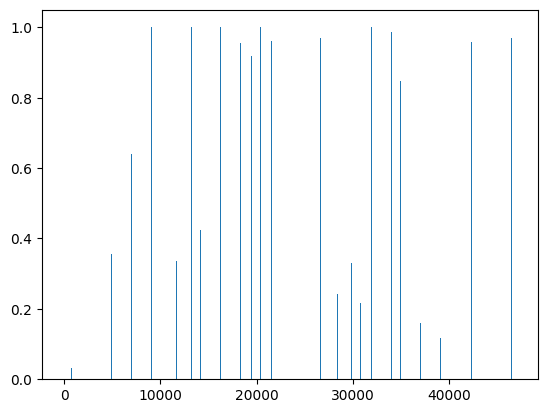

In [ ]:
## PASSO 8 - Visualização

descritor_hog_flatted = descritor_hog.flatten()
descritor_hog_flatted_len = len(descritor_hog_flatted)
descritor_hog_flatted_arange = np.arange(descritor_hog_flatted_len)

plt.bar(descritor_hog_flatted_arange, descritor_hog_flatted)
plt.show()